<a href="https://colab.research.google.com/github/kaustavd7/CGS616_Assn3/blob/main/Modelling_speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [ ]:
MAX_SEQ_LEN = 50
MFCC_DIM = 40
EGEMAPS_DIM = 24
LABEL_CSV = "Final_detailed_labels_train.csv"
FEATURE_DIR = "speech_features"
path = '/content/drive/MyDrive/HCC_Project'
data_path = os.path.join(path, 'speech_features')
label_path = os.path.join(path, 'labels/Final_detailed_labels_train.csv')

In [ ]:
def load_and_pad_features(pid):
    folder = os.path.join(data_path, f"{pid}_features")

    def load_csv_clean(path, expected_dim):
        df = pd.read_csv(path, delimiter=';')
        df.drop([df.columns[0]], axis = 1, inplace = True)
        df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
        arr = df.values.astype(np.float32)
        if arr.shape[0] > MAX_SEQ_LEN:
            arr = arr[:MAX_SEQ_LEN]
        elif arr.shape[0] < MAX_SEQ_LEN:
            pad = np.zeros((MAX_SEQ_LEN - arr.shape[0], expected_dim), dtype=np.float32)
            arr = np.vstack([arr, pad])
        return arr

    mfcc = load_csv_clean(os.path.join(folder, f"{pid}_OpenSMILE2.3.0_mfcc.csv"), MFCC_DIM)
    egemaps = load_csv_clean(os.path.join(folder, f"{pid}_OpenSMILE2.3.0_egemaps.csv"), EGEMAPS_DIM)
    return mfcc, egemaps


In [ ]:
def create_tf_dataset(label_csv, batch_size=16):
    df = pd.read_csv(label_csv)
    pids = df["Participant"].tolist()
    anxiety = df["Anxiety_severity"].tolist()
    ptsd = df["PTSD_label"].tolist()

    mfcc_data, egemaps_data = [], []
    for pid in pids:
        mfcc, egemaps = load_and_pad_features(pid)
        mfcc_data.append(mfcc)
        egemaps_data.append(egemaps)

    X_mfcc = np.stack(mfcc_data)
    X_egemaps = np.stack(egemaps_data)
    y_anx = np.array(anxiety, dtype=np.float32)
    y_ptsd = np.array(ptsd, dtype=np.float32)

    dataset = tf.data.Dataset.from_tensor_slices(((X_mfcc, X_egemaps), (y_anx, y_ptsd)))
    return dataset.shuffle(256).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
def build_model():
    mfcc_input = tf.keras.Input(shape=(MAX_SEQ_LEN, MFCC_DIM))
    egemaps_input = tf.keras.Input(shape=(MAX_SEQ_LEN, EGEMAPS_DIM))

    x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False))(mfcc_input)
    x2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False))(egemaps_input)

    fused = tf.keras.layers.Concatenate()([x1, x2])
    fused = tf.keras.layers.Dense(128, activation='relu')(fused)
    fused = tf.keras.layers.Dropout(0.3)(fused)

    out_anxiety = tf.keras.layers.Dense(1, name="anxiety_output")(fused)
    out_ptsd = tf.keras.layers.Dense(1, activation='sigmoid', name="ptsd_output")(fused)

    model = tf.keras.Model(inputs=[mfcc_input, egemaps_input], outputs=[out_anxiety, out_ptsd])
    return model


In [ ]:
full_ds = create_tf_dataset(label_path)
train_ds = full_ds.take(int(0.8 * len(full_ds)))
val_ds = full_ds.skip(int(0.8 * len(full_ds)))

In [ ]:
model = build_model()
model.compile(
    optimizer='adam',
    loss={"anxiety_output": "mse", "ptsd_output": "binary_crossentropy"},
    loss_weights={"anxiety_output": 1.0, "ptsd_output": 0.5},
    metrics={"ptsd_output": ["accuracy"]}
)

history = model.fit(train_ds, validation_data=val_ds, epochs=100)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step - anxiety_output_loss: 169.2281 - loss: 169.6144 - ptsd_output_accuracy: 0.4280 - ptsd_output_loss: 0.7726 - val_anxiety_output_loss: 159.9960 - val_loss: 172.9599 - val_ptsd_output_accuracy: 0.5556 - val_ptsd_output_loss: 0.7106
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - anxiety_output_loss: 131.7676 - loss: 132.1455 - ptsd_output_accuracy: 0.4851 - ptsd_output_loss: 0.7558 - val_anxiety_output_loss: 65.8166 - val_loss: 69.0564 - val_ptsd_output_accuracy: 0.6296 - val_ptsd_output_loss: 0.6520
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - anxiety_output_loss: 71.3918 - loss: 71.7360 - ptsd_output_accuracy: 0.5539 - ptsd_output_loss: 0.6884 - val_anxiety_output_loss: 22.2516 - val_loss: 21.3991 - val_ptsd_output_accuracy: 0.8889 - val_ptsd_output_loss: 0.4373
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - anxiety_output_loss: 44.1485 - loss: 44.4928 - ptsd_output_accuracy: 0.6249 - ptsd_output_loss: 0.6886 - val_anxi

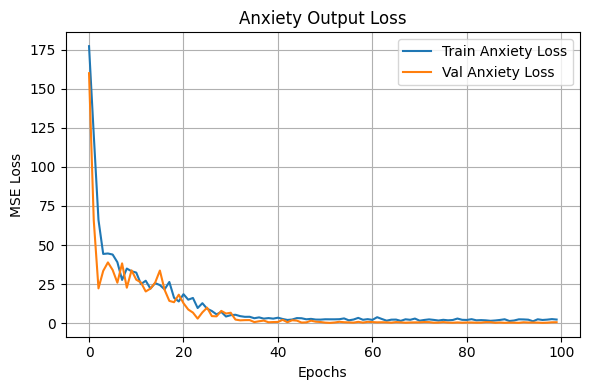

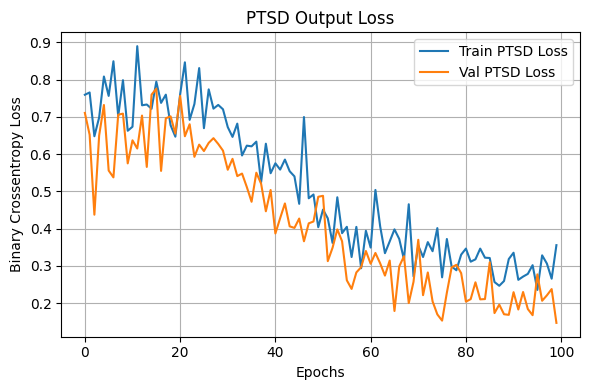

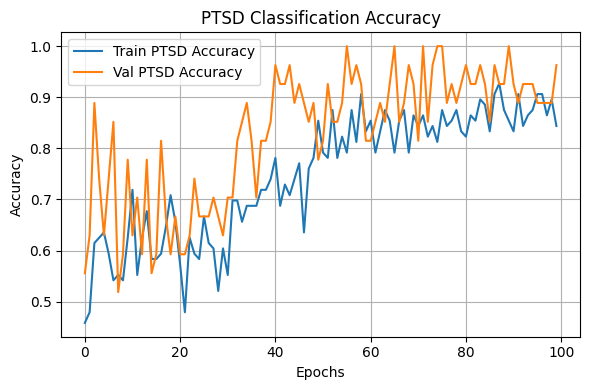

In [11]:
hist = history.history

# Plot 1: Anxiety Loss
plt.figure(figsize=(6, 4))
plt.plot(hist["anxiety_output_loss"], label="Train Anxiety Loss")
plt.plot(hist["val_anxiety_output_loss"], label="Val Anxiety Loss")
plt.title("Anxiety Output Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: PTSD Loss
plt.figure(figsize=(6, 4))
plt.plot(hist["ptsd_output_loss"], label="Train PTSD Loss")
plt.plot(hist["val_ptsd_output_loss"], label="Val PTSD Loss")
plt.title("PTSD Output Loss")
plt.xlabel("Epochs")
plt.ylabel("Binary Crossentropy Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: PTSD Accuracy
plt.figure(figsize=(6, 4))
plt.plot(hist["ptsd_output_accuracy"], label="Train PTSD Accuracy")
plt.plot(hist["val_ptsd_output_accuracy"], label="Val PTSD Accuracy")
plt.title("PTSD Classification Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/HCC_Project/speechmodel.keras')